In [1]:
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
import networkx as nx
import statistics

In [2]:
plt.rcParams.update({'font.size': 15})

## Parameters

In [3]:
eps_I_list = [0.1,0.25,0.4]
eps_T_list = [0,0.01,0.1,0.4]

In [4]:
K = 10
nb_ideas = 20
k_threshold = np.full(nb_ideas,K)

In [5]:
PARAMETERS = {'temporal_gap' : 3600*2,              # Temporal gap between static networks (sec)
              'nb_nodes' : 680,
              'nb_clusters' : 10,                   # Nb of clusters in networks
              'cluster_size' : 68,                  # Cluster size
              'nb_ideas' : len(k_threshold),                # Nb of ideas
              'nb_links' : 400,                     # nb of links in networks
              'memory_contacts' : 7,                # Tracing memory (days)
              'max_time_quar' : 10,                 # Quarantine duration (days)
              'max_time_iso' : 25,                  # Isolation duration (days)
              'eps_Is' : eps_I_list,                # Isolation effectivity
              'eps_Ts' : eps_T_list,                # Tracing effectivity
              'recov_time' : 25,                    # recovery time
              'k_threshold' : k_threshold,          # Knowledge spreading parameter
              'times' : 200,                      # Number of repetition of the simulation
              'seed' : 11,                          # Random seed 
              'symptomatics' : 0.8,                 # Fraction of symptomatic individuals 
              'testing' : 0.0,                      # Fraction of asymptomatics who are detected via random testing
              'net' : 'synth',
              'store':{'to_store': True,            # Save the results?
                       'path_to_store':'RESULTS/'}} # Target folder to save the results
                       #'path_to_store':'lore_varie/RESULTS/'}} # Target folder to save the results

In [6]:
nb_clusters = PARAMETERS['nb_clusters']
nb_nodes = PARAMETERS['nb_nodes']
cluster_size = int(nb_nodes/nb_clusters)
if PARAMETERS['cluster_size'] != cluster_size:
    print('ERRORE!!!')
L = PARAMETERS['nb_links']

In [7]:
rounds = True
round_days = 10

## Functions

In [8]:
def update_load_path(load_path,eps_I,eps_T):
    
    if all(el == PARAMETERS['k_threshold'][0] for el in PARAMETERS['k_threshold']): # True if all K are the same
        name='/epsI_' + str(eps_I)+'_epsT_'+str(eps_T) + '_kThresh_'+str(PARAMETERS['k_threshold'][0])+'/'
    else:
         name='/epsI_' + str(eps_I)+'_epsT_'+str(eps_T) + '_kThresh_mix2/'
    load_path += name

    return load_path

## Load eff edgelist

In [9]:
#for p_intra in [0.00483,0.00806,0.00838,0.00849,0.00854,0.00858,0.0086,0.00863,0.00865]: #5 clusters
#for p_intra in [0.00621,0.01485,0.01609,0.01655,0.01679,0.01694,0.01704,0.01717,0.01727]: #10 clusters
#for p_intra in [0.00725,0.02562,0.02981,0.03154,0.03247,0.03306,0.03347,0.03399,0.03443]: #20 clusters

In [10]:
#p_intra = 0.00865 #0.00854 #0.00483 #5 clusters
p_intra =  0.01679  #0.00621 #10 clusters
p_inter = 2*L/(nb_clusters*(nb_clusters-1)*cluster_size**2) - (cluster_size-1)*p_intra/((nb_clusters-1)*cluster_size)
print('p',p_intra/p_inter)
graph_name = '%dnodes/%dclusters_%dnodes/temporal_net_p_intra%.2E_p_inter%.2E'%(nb_nodes,nb_clusters,cluster_size,p_intra,p_inter)
if rounds:
    graph_name += '_rounds%ddays'%round_days

eps_I = eps_I_list[0]
eps_T = eps_T_list[0]
print('eps_I',eps_I,'eps_T',eps_T)

p 199.36675835149904
eps_I 0.1 eps_T 0


In [19]:
path = PARAMETERS['store']['path_to_store'] + graph_name
path = update_load_path(path,eps_I,eps_T)
print(path)
for real in range(PARAMETERS['times']): # for each realization
    print(real)
    globals()['r%d_eff_edgelist'%(real)] = np.load(path + 'eff_edgelist/%d_eff_edgelist.npy'%(real),allow_pickle=True)



RESULTS/680nodes/10clusters_68nodes/temporal_net_p_intra1.68E-02_p_inter8.42E-05_rounds10days/epsI_0.1_epsT_0_kThresh_10/
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [20]:
time_len = len(r0_eff_edgelist)

Compute effective $p$:

In [21]:
for real in range(PARAMETERS['times']): # for each realization
    print(real)
    intra_links = []
    inter_links = []
    for t in range(time_len):
        #print(t)
        G = nx.Graph()
        G.add_edges_from(globals()['r%d_eff_edgelist'%(real)][t])
        intra_cluster_links = []
        extra_cluster_links = []
        for n in range(nb_clusters):
            intra_cluster_n = 0
            extra_cluster_n = 0
            for node in range(n*cluster_size, (n+1)*cluster_size):
                if node in G:
                    neighs = G.neighbors(node)
                    for neigh_node in neighs:
                        if n*cluster_size <= neigh_node < (n+1)*cluster_size:
                            intra_cluster_n += 1
                        else:
                            extra_cluster_n += 1
            #print('intra_cluster_n',intra_cluster_n)
            intra_cluster_n /= 2
            extra_cluster_n /= 2

            intra_cluster_links.append(intra_cluster_n)
            extra_cluster_links.append(extra_cluster_n)
            #print('len intra_cluster_links',len(intra_cluster_links))
            #n += 1

        intra_links.append(np.mean(intra_cluster_links)) # media sui diversi cluster
        inter_links.append(np.mean(extra_cluster_links))
        
    if real == 0:
        intra_links_all = np.array(intra_links.copy())
        inter_links_all = np.array(inter_links.copy())
    else:
        intra_links_all = np.vstack((intra_links_all, np.array(intra_links.copy()))) # put together in a matrix
        inter_links_all = np.vstack((inter_links_all, np.array(inter_links.copy()))) 


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [22]:
cluster_size

68

In [23]:
# compute average on realizations:
intra_links_all_mean = np.mean(intra_links_all,axis=0)
#intra_links_all_sem = sem(intra_links_all,axis=0)

inter_links_all_mean = np.mean(inter_links_all,axis=0)
#inter_links_all_sem = sem(inter_links_all,axis=0)

In [24]:
estimated_p_intra = np.array(intra_links_all_mean)/(cluster_size*(cluster_size-1)/2)
print('estimated p_intra',estimated_p_intra)

estimated p_intra [0.01562774 0.01720808 0.01738367 ... 0.01733055 0.01732968 0.01706958]


In [25]:
nb_nodes = cluster_size*PARAMETERS['nb_clusters']
estimated_p_inter = np.array(inter_links_all_mean)/(cluster_size*(nb_nodes - cluster_size)/2)
print('estimated p_inter',estimated_p_inter)

estimated p_inter [4.32525952e-05 1.20146098e-04 1.24951942e-04 ... 1.39177240e-04
 7.19915417e-05 6.24038831e-05]


In [26]:
est_p = estimated_p_intra/estimated_p_inter

Il problema degli infiniti si risolve così:

1) Calcolando la mediana sui tempi al posto della media

In [27]:
round(statistics.median(est_p),2)

200.25

2) calcolando la media dell'inverso

In [28]:
est_p_inv = estimated_p_inter/estimated_p_intra
round(1/np.mean(est_p_inv),2)

197.31

In [29]:
#####################

Compute effective nb of links:

In [30]:
for real in range(PARAMETERS['times']): # for each realization
    #print(real)
    nb_edges = []
    for edgelist in globals()['r%d_eff_edgelist'%(real)]:
        nb_edges.append(len(edgelist))
        
    if real == 0:
        nb_edges_all = np.array(nb_edges.copy())
    else:
        nb_edges_all = np.vstack((nb_edges_all, np.array(nb_edges.copy()))) # put together in a matrix


In [31]:
# compute average
nb_edges_all_mean = np.mean(nb_edges_all,axis=0)


## Save data for plots

In [32]:
# solo la prima volta

filename = 'Figures_data/%dnodes/%dclusters_%dnodes/eff_p_p_intra_%.2E_epsI_%.2f_epsT_%.3f_kThresh_%.3f'%(nb_nodes,nb_clusters,cluster_size,p_intra,eps_I,eps_T,K)
if rounds:
    filename += '_rounds%ddays'%round_days
filename += '.npy'
np.save(filename,est_p)


In [33]:
# solo la prima volta

filename = 'Figures_data/%dnodes/%dclusters_%dnodes/eff_p_intra_p_intra_%.2E_epsI_%.2f_epsT_%.3f_kThresh_%.3f'%(nb_nodes,nb_clusters,cluster_size,p_intra,eps_I,eps_T,K)
if rounds:
    filename += '_rounds%ddays'%round_days
filename += '.npy'
np.save(filename,estimated_p_intra)


In [34]:
# solo la prima volta

filename = 'Figures_data/%dnodes/%dclusters_%dnodes/eff_p_inter_p_intra_%.2E_epsI_%.2f_epsT_%.3f_kThresh_%.3f'%(nb_nodes,nb_clusters,cluster_size,p_intra,eps_I,eps_T,K)
if rounds:
    filename += '_rounds%ddays'%round_days
filename += '.npy'
np.save(filename,estimated_p_inter)


In [35]:
# solo la prima volta

filename = 'Figures_data/%dnodes/%dclusters_%dnodes/eff_links_p_intra_%.2E_epsI_%.2f_epsT_%.3f_kThresh_%.3f'%(nb_nodes,nb_clusters,cluster_size,p_intra,eps_I,eps_T,K)
if rounds:
    filename += '_rounds%ddays'%round_days
filename += '.npy'
np.save(filename,nb_edges_all_mean)


## Load data for plots

In [36]:
filename = 'Figures_data/%dnodes/%dclusters_%dnodes/eff_p_p_intra_%.2E_epsI_%.2f_epsT_%.3f_kThresh_%.3f'%(nb_nodes,nb_clusters,cluster_size,p_intra,eps_I,eps_T,K)
if rounds:
    filename += '_rounds%ddays'%round_days
filename += '.npy'

est_p = np.load(filename,allow_pickle=True)

In [37]:
filename = 'Figures_data/%dnodes/%dclusters_%dnodes/eff_p_intra_p_intra_%.2E_epsI_%.2f_epsT_%.3f_kThresh_%.3f'%(nb_nodes,nb_clusters,cluster_size,p_intra,eps_I,eps_T,K)
if rounds:
    filename += '_rounds%ddays'%round_days
filename += '.npy'

estimated_p_intra = np.load(filename,allow_pickle=True)

In [38]:
filename = 'Figures_data/%dnodes/%dclusters_%dnodes/eff_p_inter_p_intra_%.2E_epsI_%.2f_epsT_%.3f_kThresh_%.3f'%(nb_nodes,nb_clusters,cluster_size,p_intra,eps_I,eps_T,K)
if rounds:
    filename += '_rounds%ddays'%round_days
filename += '.npy'

estimated_p_inter = np.load(filename,allow_pickle=True)

In [39]:
filename = 'Figures_data/%dnodes/%dclusters_%dnodes/eff_links_p_intra_%.2E_epsI_%.2f_epsT_%.3f_kThresh_%.3f'%(nb_nodes,nb_clusters,cluster_size,p_intra,eps_I,eps_T,K)
if rounds:
    filename += '_rounds%ddays'%round_days
filename += '.npy'

nb_edges_all_mean = np.load(filename,allow_pickle=True)

## Plot

In [40]:
col1 = '#8f8a93'
col2 = '#fe019a'

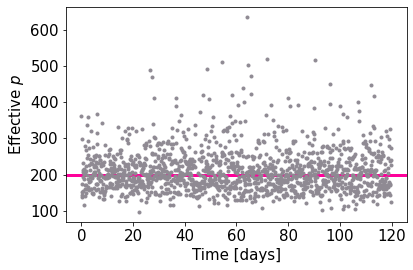

In [41]:
days = np.array(range(time_len))*PARAMETERS['temporal_gap']/3600/24
plt.axhline(y=p_intra/p_inter,c=col2,linewidth=3,linestyle='-')
plt.plot(days,est_p,'o',markersize=3,c=col1)

plt.xlabel('Time [days]')
plt.ylabel('Effective $p$')
figname = '../../figs/%dnodes/Eff_links/%dclusters_%dnodes/eff_p_p_intra_%.2E_epsI_%.2f_epsT_%.3f_kThresh_%.3f'%(nb_nodes,nb_clusters,cluster_size,p_intra,eps_I,eps_T,K)
if rounds:
    figname += '_rounds%ddays'%round_days
figname += '.pdf'
plt.tight_layout()
plt.savefig(figname)
plt.show()

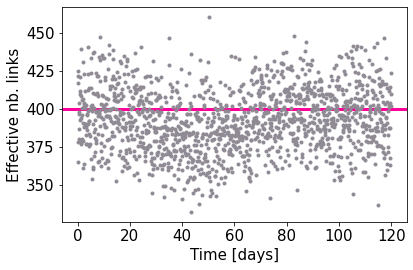

In [42]:
days = np.array(range(time_len))*PARAMETERS['temporal_gap']/3600/24

plt.axhline(y=400,c=col2,linewidth=3)
plt.plot(days,nb_edges_all_mean,'o',markersize=3,c=col1)

plt.xlabel('Time [days]')
plt.ylabel('Effective nb. links')
figname = '../../figs/%dnodes/Eff_links/%dclusters_%dnodes/eff_links_p_intra_%.2E_epsI_%.2f_epsT_%.3f_kThresh_%.3f'%(nb_nodes,nb_clusters,cluster_size,p_intra,eps_I,eps_T,K)
if rounds:
    figname += '_rounds%ddays'%round_days
figname += '.pdf'
plt.tight_layout()
plt.savefig(figname)
plt.show()

In [ ]:
eps_I

In [ ]:
p_intra/p_inter